In [20]:
import numpy as np
from solver import freq_top_opt_2D
import matplotlib.pyplot as plt
%matplotlib inline
verbose = False
if not verbose:
    import warnings
    warnings.filterwarnings("ignore")
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [21]:
res  = 0.5 # inverse of resolution
scaling = res*1e-6 # the scale applied to the physical problem
nElx =  int(14/res) # the number of elements in the X axis
nEly =  int(4/res) # the number of elements in the Y axis
nodesX = nElx + 1
nodesY = nEly + 1

In [22]:
n_metal = 3.1477 # refractive index for TiN
k_r =  5.8429  # exctinction coefficient for TiN
n_wg  = np.sqrt(15.054) # refractive index of the waveguide
n_clad = np.sqrt(4.2) # refractive index of cladding

h_core = 1e-6 / scaling
w_core = 10e-6 / scaling 
print(h_core, w_core)

2.0 20.000000000000004


In [23]:
wl = 1.55 / res  # value for the wavelentgth, i.e. 1.55 um.
k = 2 * np.pi / (wl * scaling) # value of the wavevector
delta = 3.82104208  # Effective refractive index from COMSOL
deltaT = 3.82104208

In [24]:
fR = 1 # value for the filtering radius   
maxItr = 1 # number of iterations performed by the optimizer
alg = "MMA" # algorithm: Method of  Moving Asymptotes
eta = 0.5 # parameter that controls threshold value.
beta = 1 # parameter that controls threshold sharpness.
FOM_type = "linear"
tol = 1e-3

In [25]:
dVini_Omega_1 = 0.1 # intial value of design parameters in Omega_1
dVini_Omega_3 = 0.5 # intial value of design parameters in Omega_3
nEl_Omega_3 = 1

In [26]:
volume1  = np.zeros((nEly, nElx))
volume2  = np.zeros((nEly, nElx))
volume3 = np.zeros((nEly+1, nElx+1))


volume1 [nEly//2 - int(0.5*h_core) : nEly//2 + int(0.5*h_core),nElx//2 - int(0.5*w_core) : nElx//2 + int(0.5*w_core)] = 1 # waveguide region
volume3 [(nEly+1)//2 - int(0.5*h_core) : (nEly+1)//2 + int(0.5*h_core),(nElx+1)//2 - int(0.5*w_core) : (nElx+1)//2 + int(0.5*w_core)] = 1 # waveguide region

indexes_design_region = np.array(np.where(volume1 < 1))
indexes_wg = np.array(np.where(volume3 == 1))

volume2 [nEly//2 - int(0.5*h_core)-nEl_Omega_3:nEly//2 + int(0.5*h_core)+nEl_Omega_3,nElx//2 - int(0.5*w_core)-nEl_Omega_3:nElx//2 + int(0.5*w_core)+nEl_Omega_3] = 1 # non-constraint region
volume3 = volume2 - volume1
indexes_heating = np.array(np.where(volume3 > 0.5))
from wg_index import calc_index_constraint

indexes_constraint = (calc_index_constraint(indexes_design_region, indexes_heating)).astype(int)

dVini = dVini_Omega_1 *  np.ones_like(np.array(indexes_design_region[0,:]).flatten()) 
dVini [indexes_constraint] = dVini_Omega_3

random = True
if random:
   dVini = np.random.rand(len(dVini))

In [27]:
vol_cons_val = 0.5
heat_cons_val =  0.0

In [28]:
RHS_heater = indexes_wg
val_heater = 100e-3 * np.ones_like(indexes_design_region)
dz = 2e-4
k_wg = 148 #/ scaling
k_clad = 1.4 #/ scaling
k_metal = 28

In [29]:
component = 0 # 0=E, 1=H
node_RHS =  int(component*nodesX*nodesY + 0.5*nodesX*nodesY+0.3*nodesX)
idx_RHS = np.array([node_RHS, node_RHS-0.6*nodesX+1]).astype(int) #np.array([node_RHS]).astype(int) #np.array([node_RHS, node_RHS-0.5*nodesX+1]).astype(int)
val_RHS = np.array([0.5E-5*(1+0.5E-4j), -0.5E-5*(1+0.5E-4j)]) * 10

In [30]:
solver = freq_top_opt_2D( nElx, 
                          nEly,
                          nElx, 
                          nEly,
                          dVini,
                          w_core,
                          h_core,
                          n_metal,
                          k_r,
                          n_wg,
                          n_clad,
                          wl,
                          delta,
                          deltaT,  
                          fR,
                          eta,
                          beta,
                          scaling,
                          vol_cons_val,
                          FOM_type,
                          indexes_wg,
                          indexes_wg,
                          indexes_design_region,
                          indexes_design_region,
                          heat_cons_val,
                          indexes_heating,
                          indexes_heating,
                          continuation_scheme= False,
                          heating_constraint= False,
                          volume_constraint= False,
                          eliminate_excitation= False,
                          dz=dz,
                          k_wg = k_wg,
                          k_clad = k_clad,
                          k_metal = k_metal,
                          debug=False
                        )

Calculated effective index:  (3.755043143582295-2.8481237955528215e-19j)
FOM partial:  -205294.98246695314
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
----------------------------------------------
Optimization iteration:  0
Calculated effective index:  (3.7773993485661346-1.9883185086478617e-17j)
FOM partial:  -157320.7079308803
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
----------------------------------------------
Total optimization time: 0 min 0 s
----------------------------------------------


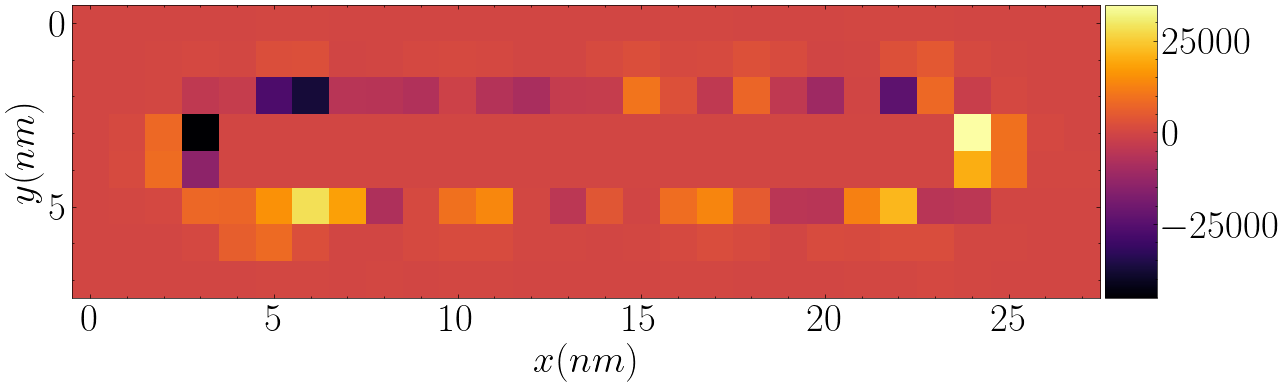

In [31]:
dVs = solver.optimize(maxItr, tol, alg, idx_RHS=idx_RHS, val_RHS=val_RHS)
sens = solver.plot_sensitivities()

Calculated effective index:  (3.7773993485661346-1.9883185086478617e-17j)
FOM partial:  -157320.7079308803
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
Calculated effective index:  (3.777399348566163-1.3485683620911058e-17j)
FOM partial:  -157320.70793069783
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
Calculated effective index:  (3.7773993485662394-4.3651664888013836e-17j)
FOM partial:  -157320.707930153
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
Calculated effective index:  (3.7773993485720743+1.7734950949517906e-18j)
FOM partial:  -157320.70788620983
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
Calculated effective index:  (3.7773993485975974-2.734231894700399e-17j)
FOM partial:  -157320.70771309052
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
Calculated effective index:  (3.7773993485953

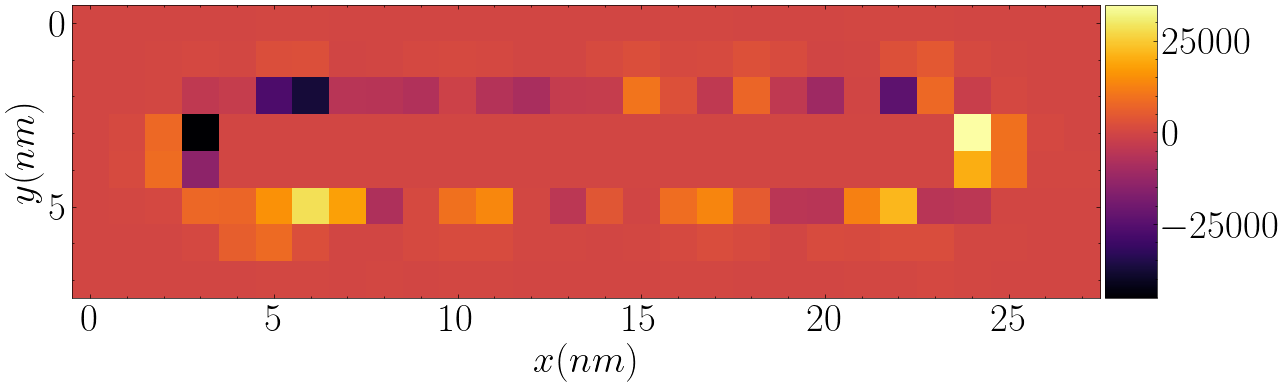

In [32]:
sens_fd = solver.sens_check (dVini, idx_RHS, val_RHS, 1e-5)

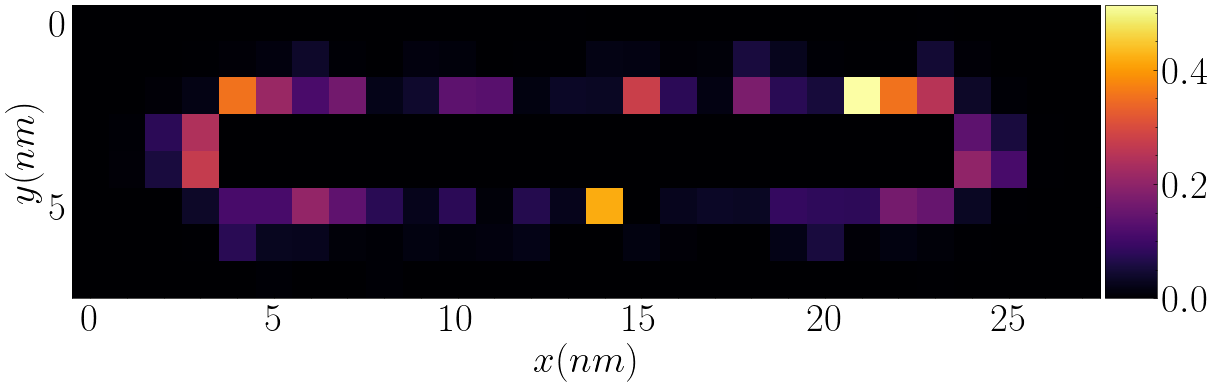

0.513862391183693
0.02297615568495632
-0.11379078184108948
0.003827190829057421
7.110014576341864e-05
0.0
34834.117353551635
34833.979135146365


In [41]:
def plot_sens(sens): 
    #init_plot_params(28)
    fig, ax = plt.subplots(figsize=(14,10))
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    region = np.zeros((nEly, nElx))
    region [indexes_design_region[0,:], indexes_design_region[1,:]] = np.reshape(sens, np.shape(region [indexes_design_region[0,:], indexes_design_region[1,:]]))

    im = ax.imshow(np.real(region), cmap='inferno')#, vmax=0.0025, vmin=-0.001)
    #ax.contour(np.real(dis.eps), levels=2, cmap='binary', linewidth=2, alpha=1)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax.set_xlabel('$x (nm)$')
    ax.set_ylabel('$y (nm)$')

    plt.show()

sens1 = np.zeros((nEly, nElx))
sens2 = np.zeros((nEly, nElx))
sens1[indexes_design_region[0,:], indexes_design_region[1,:]] = sens #- 0.002058440842513084 

#/ np.max(sens)
sens2[indexes_design_region[0,:], indexes_design_region[1,:]] = sens_fd  #/ np.max(sens_fd)

rel_err = np.zeros((nEly, nElx))
abs_err = np.zeros((nEly, nElx))

rel_err[indexes_design_region[0,:], indexes_design_region[1,:]] = (np.abs(np.real(sens1-sens2))/np.abs(np.real(sens1))) [indexes_design_region[0,:], indexes_design_region[1,:]] #(np.abs(sens1-sens2)/abs(sens1)) [indexes_design_region[0,:], indexes_design_region[1,:]]
abs_err[indexes_design_region[0,:], indexes_design_region[1,:]] = (np.real(sens1-sens2)) [indexes_design_region[0,:], indexes_design_region[1,:]] #(np.abs(sens1-sens2)/abs(sens1)) [indexes_design_region[0,:], indexes_design_region[1,:]]

#plt.imshow(sens2)
#print(np.max(sens2))
#print(np.min(sens2))
abs_error = (np.abs(np.real(sens-sens_fd)))
rel_error = (np.abs(np.real(sens-sens_fd)/np.abs(sens)))
plot_sens(abs_error)
print(np.max(abs_err))
print(np.mean(abs_err))
print(np.min(abs_err))
print(np.max(rel_err))
print(np.mean(rel_err))
print(np.min(rel_err))

#plt.imshow(rel_err)
#print(np.mean(rel_err))
#print(np.min(rel_err))
print(np.max(sens1))
print(np.max(sens2))
plt.show()

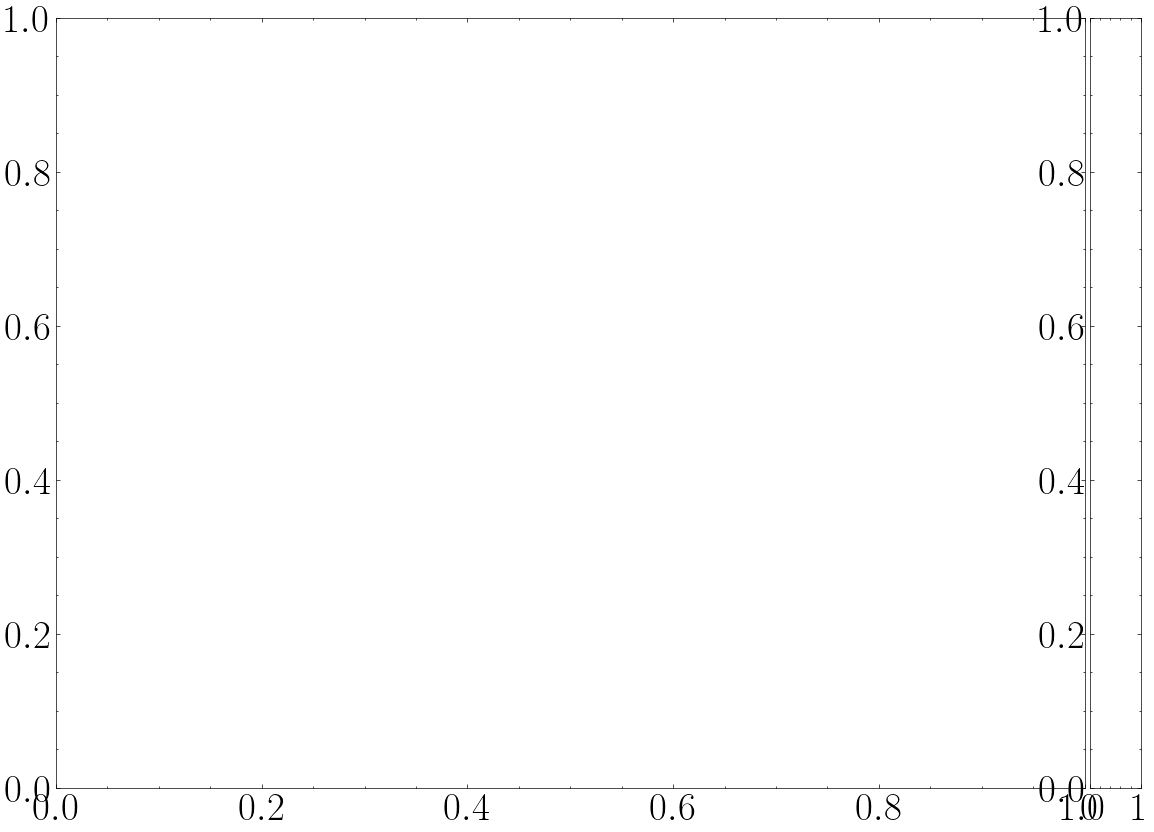

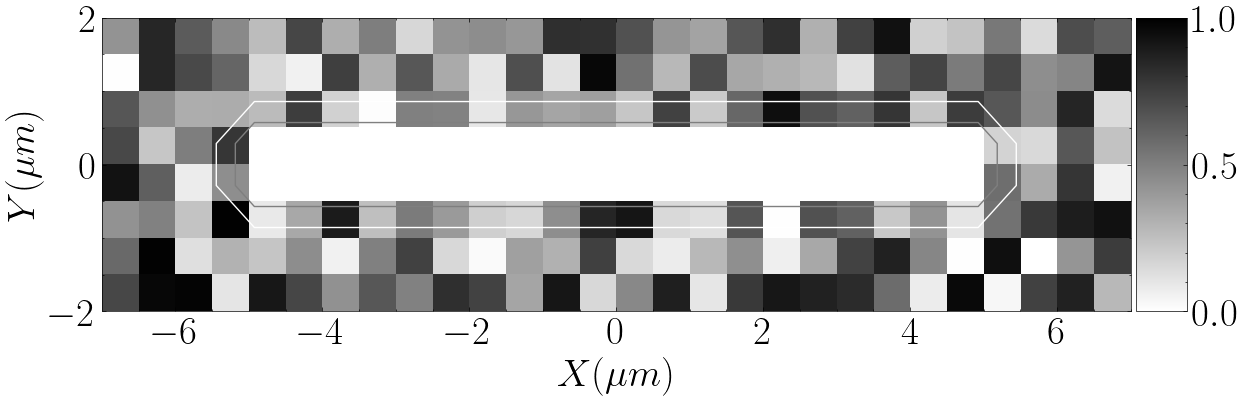

In [34]:
solver.plot_material_interpolation()

In [36]:
print(np.shape(indexes_design_region[0,:]))
idx = 184 // 2
idx_1 = 136 //2
idx_2 = 166
idx_3 = 32
print("-----------------------------------------------------")
print("INDEX 1:", idx)
print("-----------------------------------------------------")
print("Value of calculated sensitivity: ",np.real(sens[idx]))
print("Value of finite-difference sensitivity: ",sens_fd[idx])
print("Absolute error: ", abs_err[indexes_design_region[0,idx], indexes_design_region[1,idx]])
print("Relative error: ", rel_err[indexes_design_region[0,idx], indexes_design_region[1,idx]])
print("-----------------------------------------------------")
print("INDEX 2:", idx_2)
print("-----------------------------------------------------")
print("Value of calculated sensitivity: ",np.real(sens[idx_2]))
print("Value of finite-difference sensitivity: ",sens_fd[idx_2])
print("Absolute error: ", abs_err[indexes_design_region[0,idx_2], indexes_design_region[1,idx_2]])
print("Relative error: ", rel_err[indexes_design_region[0,idx_2], indexes_design_region[1,idx_2]])
print("-----------------------------------------------------")
print("INDEX 3:", idx_3)
print("-----------------------------------------------------")
print("Value of calculated sensitivity: ",np.real(sens[idx_3]))
print("Value of finite-difference sensitivity: ",sens_fd[idx_3])
print("Absolute error: ", abs_err[indexes_design_region[0,idx_3], indexes_design_region[1,idx_3]])
print("Relative error: ", rel_err[indexes_design_region[0,idx_3], indexes_design_region[1,idx_3]])

(184,)
-----------------------------------------------------
INDEX 1: 92
-----------------------------------------------------
Value of calculated sensitivity:  46.610969274008646
Value of finite-difference sensitivity:  46.610546996816986
Absolute error:  0.00042227719166021416
Relative error:  9.059609749323228e-06
-----------------------------------------------------
INDEX 2: 166
-----------------------------------------------------
Value of calculated sensitivity:  130.17920616799796
Value of finite-difference sensitivity:  130.17855817452073
Absolute error:  0.0006479934772301021
Relative error:  4.977703400601922e-06
-----------------------------------------------------
INDEX 3: 32
-----------------------------------------------------
Value of calculated sensitivity:  273.9902319756614
Value of finite-difference sensitivity:  273.9826566539705
Absolute error:  0.00757532169092201
Relative error:  2.7648145104658063e-05


In [38]:
def check_sensitivities_step(delta_dV, dVini, alg, tol, maxItr,  idx_RHS, val_RHS):
    dVs = solver.optimize(maxItr, tol, alg, idx_RHS=idx_RHS, val_RHS=val_RHS)
    sens1 = solver.plot_sensitivities()
    sens2 = solver.sens_check (dVini, idx_RHS, val_RHS, delta_dV)
    sens_error = sens1 - sens2
    rel_error = np.max(np.abs(sens_error))
    return rel_error

In [39]:
delta_dV_list = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-6, 1e-7, 1e-8])

Calculated effective index:  (3.755043143582295-2.8481237955528215e-19j)
FOM partial:  -205294.98246695314
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
----------------------------------------------
Optimization iteration:  0
Calculated effective index:  (3.7773993485661346-1.9883185086478617e-17j)
FOM partial:  -157320.7079308803
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
----------------------------------------------
Total optimization time: 0 min 0 s
----------------------------------------------


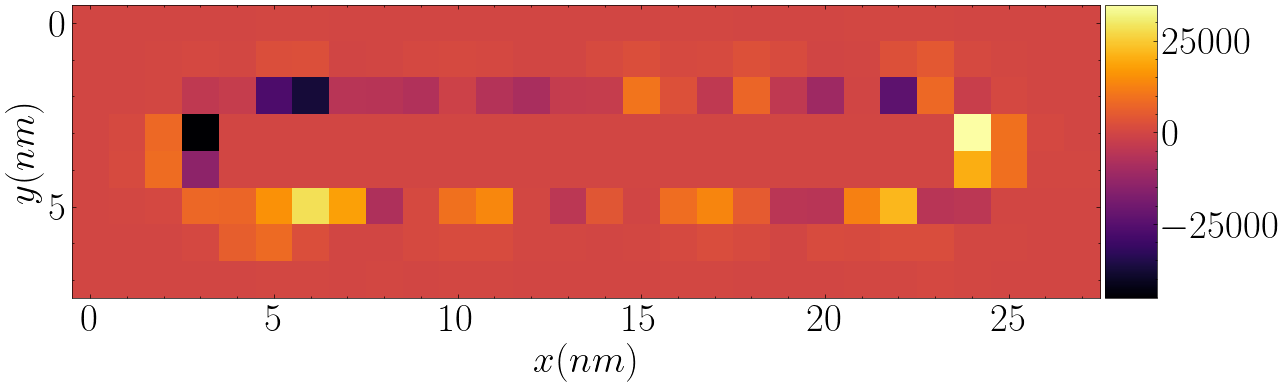

Calculated effective index:  (3.7773993485661346-1.9883185086478617e-17j)
FOM partial:  -157320.7079308803
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
Calculated effective index:  (3.777399348827569+1.6809907123516528e-17j)
FOM partial:  -157320.70614520548
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
Calculated effective index:  (3.777399349538166+6.676996425071271e-19j)
FOM partial:  -157320.70107306977
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
Calculated effective index:  (3.7773993985574847-1.0532874319060701e-18j)
FOM partial:  -157320.32948445226
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
Calculated effective index:  (3.7773996153523743+8.203591601678336e-18j)
FOM partial:  -157318.77506504854
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
Calculated effective index:  (3.7773996124437

KeyboardInterrupt: 

In [40]:
errors =  np.zeros_like(delta_dV_list)
for i in range(len(delta_dV_list)):
    errors [i] = check_sensitivities_step(delta_dV_list[i], dVini, alg, tol, int(maxItr),  idx_RHS, val_RHS)

In [ ]:
print(errors)